# DAT560: Generative AI

* Lectures: Vinay Setty, Petra Galuskova.
* Teaching Assistant: Gabriel Iturra-Bocaz

## Cat vs Dog Classification using CNN and ResNet

This notebook demonstrates how to classify images of **cats** and **dogs** using PyTorch. We start with a simple Convolutional Neural Network (CNN) to build intuition, then leverage a deeper pretrained model, **ResNet**, for improved performance. We use a subset of the CIFAR‑10 dataset, which contains labeled images of both cats and dogs among other classes.

## Prerequisites

Run the cell below to import required libraries. Make sure you have **PyTorch** and **torchvision** installed. If you're running this in Google Colab, it already includes these packages.

This notebook also checks whether a GPU is available and uses it when possible. If you don't have a GPU, training will run on the CPU.

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## Data Preparation

We use the **CIFAR‑10** dataset provided by `torchvision`. CIFAR‑10 contains 10 classes, two of which are *cats* (class index 3) and *dogs* (class index 5). We'll filter the dataset to include only images labeled as cats or dogs.

First, we define a transform pipeline to normalize the images. Then, we download the CIFAR‑10 training and test sets. Next, we create subsets containing only cats and dogs, and wrap them in `DataLoader` objects for batch processing.

In [2]:

# Define transformation: convert to tensor and normalize pixel values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download the CIFAR-10 training and test sets
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_full = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# CIFAR-10 class indices: 3=cat, 5=dog
cat_class = 3
dog_class = 5

# Filter indices for cats and dogs in training and test sets
train_indices = [i for i, label in enumerate(train_dataset_full.targets) if label in [cat_class, dog_class]]
test_indices = [i for i, label in enumerate(test_dataset_full.targets) if label in [cat_class, dog_class]]

# Create subsets containing only cats and dogs
train_subset = Subset(train_dataset_full, train_indices)
test_subset = Subset(test_dataset_full, test_indices)

# Data loaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_subset)}")
print(f"Number of test samples: {len(test_subset)}")


100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s]


Number of training samples: 10000
Number of test samples: 2000


### Visualize Sample Images

Let's visualize a few sample images of cats and dogs from our filtered dataset. This helps us get a sense of what the model will see. The code below takes a batch of images, denormalizes them back to the original color values, and displays a grid of images along with their labels (cat or dog).

In [8]:

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')




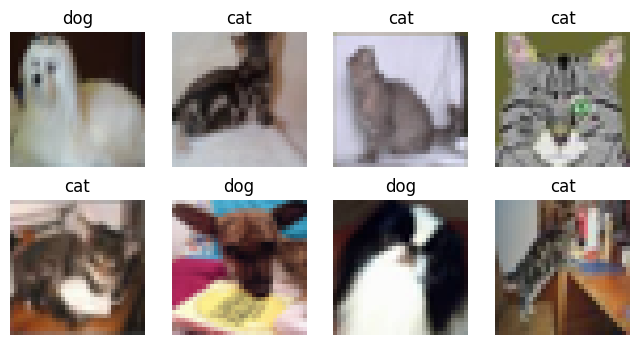

In [7]:
images, labels = next(iter(train_loader))


plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i])
    title = 'dog' if train_dataset_full.classes[labels[i]] == 'dog' else 'cat'
    plt.title(title)
plt.show()


## Building a Simple CNN

We'll start with a small convolutional neural network. The architecture includes two convolutional layers followed by max‑pooling, and two fully connected layers. After defining the model, we set up the training loop. The labels for cats and dogs are mapped to 0 and 1, respectively.

In [4]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Epoch 1/5, Loss: 0.6413, Accuracy: 0.6295
Epoch 2/5, Loss: 0.5548, Accuracy: 0.7146
Epoch 3/5, Loss: 0.5023, Accuracy: 0.7534
Epoch 4/5, Loss: 0.4641, Accuracy: 0.7783
Epoch 5/5, Loss: 0.4101, Accuracy: 0.8054
CNN Test Accuracy: 0.7545


In [9]:
# Initialize model, loss function, and optimizer
cnn_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [10]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Map original CIFAR labels (3=cat, 5=dog) to 0 and 1
        targets = (targets == dog_class).long()

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/5, Loss: 0.6430, Accuracy: 0.6270
Epoch 2/5, Loss: 0.5686, Accuracy: 0.7090
Epoch 3/5, Loss: 0.5194, Accuracy: 0.7349
Epoch 4/5, Loss: 0.4774, Accuracy: 0.7666
Epoch 5/5, Loss: 0.4347, Accuracy: 0.7940


In [11]:
cnn_model.eval()

correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = (targets == dog_class).long()
        outputs = cnn_model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == targets).sum().item()
        total_test += targets.size(0)

cnn_accuracy = correct_test / total_test
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")

CNN Test Accuracy: 0.7550


## Fine‑Tuning a ResNet Model

Next, we'll use a deeper network: **ResNet‑18**. We load a pretrained ResNet‑18 (trained on ImageNet) and replace its final fully connected layer to output two classes (cat and dog). Using a pretrained model typically accelerates convergence and yields better performance because the model has already learned general image features.

In [12]:

# Load a pretrained ResNet-18 model
resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers except the final fully connected layer (optional)
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the final layer to output 2 classes
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 2)

resnet_model = resnet_model.to(device)

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.fc.parameters(), lr=0.001)


In [13]:
# Training loop for ResNet
num_epochs_resnet = 3  # fewer epochs needed due to pretrained features
for epoch in range(num_epochs_resnet):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = (targets == dog_class).long()

        optimizer_resnet.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion_resnet(outputs, targets)
        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"ResNet Epoch {epoch+1}/{num_epochs_resnet}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


ResNet Epoch 1/3, Loss: 0.6880, Accuracy: 0.5947
ResNet Epoch 2/3, Loss: 0.6377, Accuracy: 0.6420
ResNet Epoch 3/3, Loss: 0.6218, Accuracy: 0.6564


In [14]:
# Evaluate the ResNet on the test set

resnet_model.eval()
correct_test_resnet = 0
total_test_resnet = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = (targets == dog_class).long()
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_test_resnet += (predicted == targets).sum().item()
        total_test_resnet += targets.size(0)

resnet_accuracy = correct_test_resnet / total_test_resnet
print(f"ResNet Test Accuracy: {resnet_accuracy:.4f}")


ResNet Test Accuracy: 0.6545


### Conclusion

With a relatively small number of epochs and a modest subset of CIFAR‑10, the models achieve reasonable accuracy on the cats vs dogs task. Typically, ResNet‑18 delivers better performance than our simple CNN because it leverages deeper architecture and pretrained weights.

Feel free to experiment by training for more epochs, unfreezing ResNet layers, or using a different dataset (such as the **Kaggle Dogs vs Cats** dataset) for more realistic images. You can also try other architectures like VGG or DenseNet to compare results.

### References

- Classifier with CNN network: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- Pretrained RestNest: https://pytorch.org/hub/pytorch_vision_resnet/